In [1]:
import wandb
run = wandb.init()
artifact = run.use_artifact('vincekillerz/confidence-estimation-v3/saved_model:v37', type='model')
artifact_dir = artifact.download()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: vincekillerz. Use `wandb login --relogin` to force relogin


wandb:   2 of 2 files downloaded.  


In [2]:
import os
import yaml 
from src.tools import check_file_path
config = yaml.safe_load(open(check_file_path(artifact_dir, 'config.yaml')))
model_path = check_file_path(artifact_dir, 'trained_model.pth')

In [3]:
import torch
from src.ml_orchestrator.dataset import COTDataset
from src.ml_orchestrator.loss.loss_builder import loss_builder
from src.ml_orchestrator.transforms.transforms_builder import TransformBuilder
from torch.utils.data import DataLoader

from src.models.model_builder import model_builder

transforms = config['transforms']
# del transforms['rotate']

transform_builder = TransformBuilder(transforms)

dataset_folder = check_file_path("datasets",config['ml_orchestrator']['dataset_name'])

train_dataset = COTDataset(
    confidence=config['confidence'],
    root_dir=check_file_path(dataset_folder,"train"), 
    transform_input=transform_builder.build_transforms_inputs(),
    transform_common=transform_builder.build_transform_common(), 
    config=config, 
)

valid_manually_labelled_dataset = COTDataset(
    confidence=config['confidence'],
    root_dir=check_file_path(dataset_folder,"valid_manually_labelled"), 
    transform_input=transform_builder.build_transforms_inputs(),
    transform_common=transform_builder.build_transform_common(), 
    config=config, 
)

train_loader = DataLoader(
    train_dataset, 
    batch_size=200, 
    shuffle=True,
    pin_memory=True,
    num_workers=config['ml_orchestrator']['num_workers']
)
valid_loader = DataLoader(
    valid_manually_labelled_dataset, 
    batch_size=config['ml_orchestrator']['batch_size'], 
    shuffle=True,
    pin_memory=True,
    num_workers=config['ml_orchestrator']['num_workers']
)
model = model_builder(config)
config['ml_orchestrator']['device'] = torch.device("cuda:1")
model.to(config['ml_orchestrator']['device'])
# load model
model.load_state_dict(torch.load(model_path))

device = config['ml_orchestrator']['device']
criterion = loss_builder(config,1)

/home/gharib-ml/Desktop/master_thesis_v2/src/models/asymformer/convnext.py:159: UserWarning: Overwriting convnext_tiny in registry with src.models.asymformer.convnext.convnext_tiny. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def convnext_tiny(pretrained=False,in_22k=False, **kwargs):
/home/gharib-ml/Desktop/master_thesis_v2/src/models/asymformer/convnext.py:168: UserWarning: Overwriting convnext_small in registry with src.models.asymformer.convnext.convnext_small. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def convnext_small(pretrained=False,in_22k=False, **kwargs):
/home/gharib-ml/Desktop/master_thesis_v2/src/models/asymformer/convnext.py:177: UserWarning: Overwriting convnext_base in registry with src.models.asymformer.convnext.convnext_base. This is because the name being registered conflicts with an existing name. Please check if this is no

torch.Size([200, 128, 60, 80])


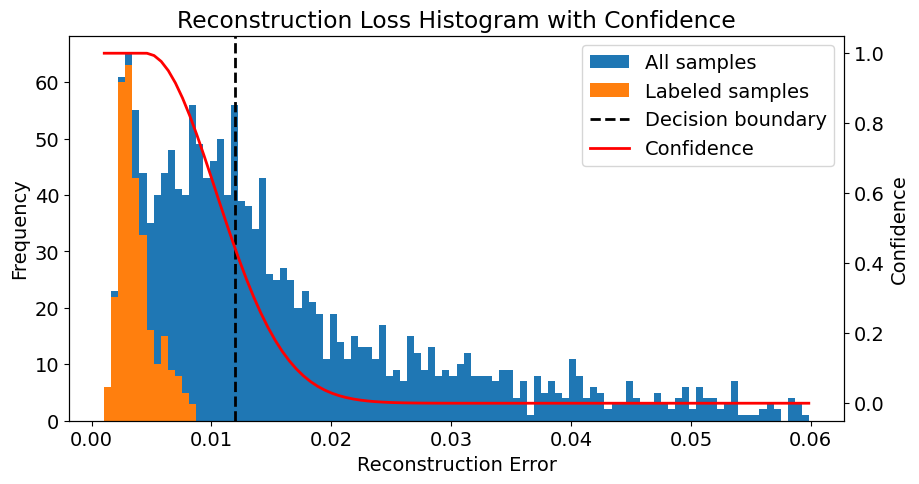

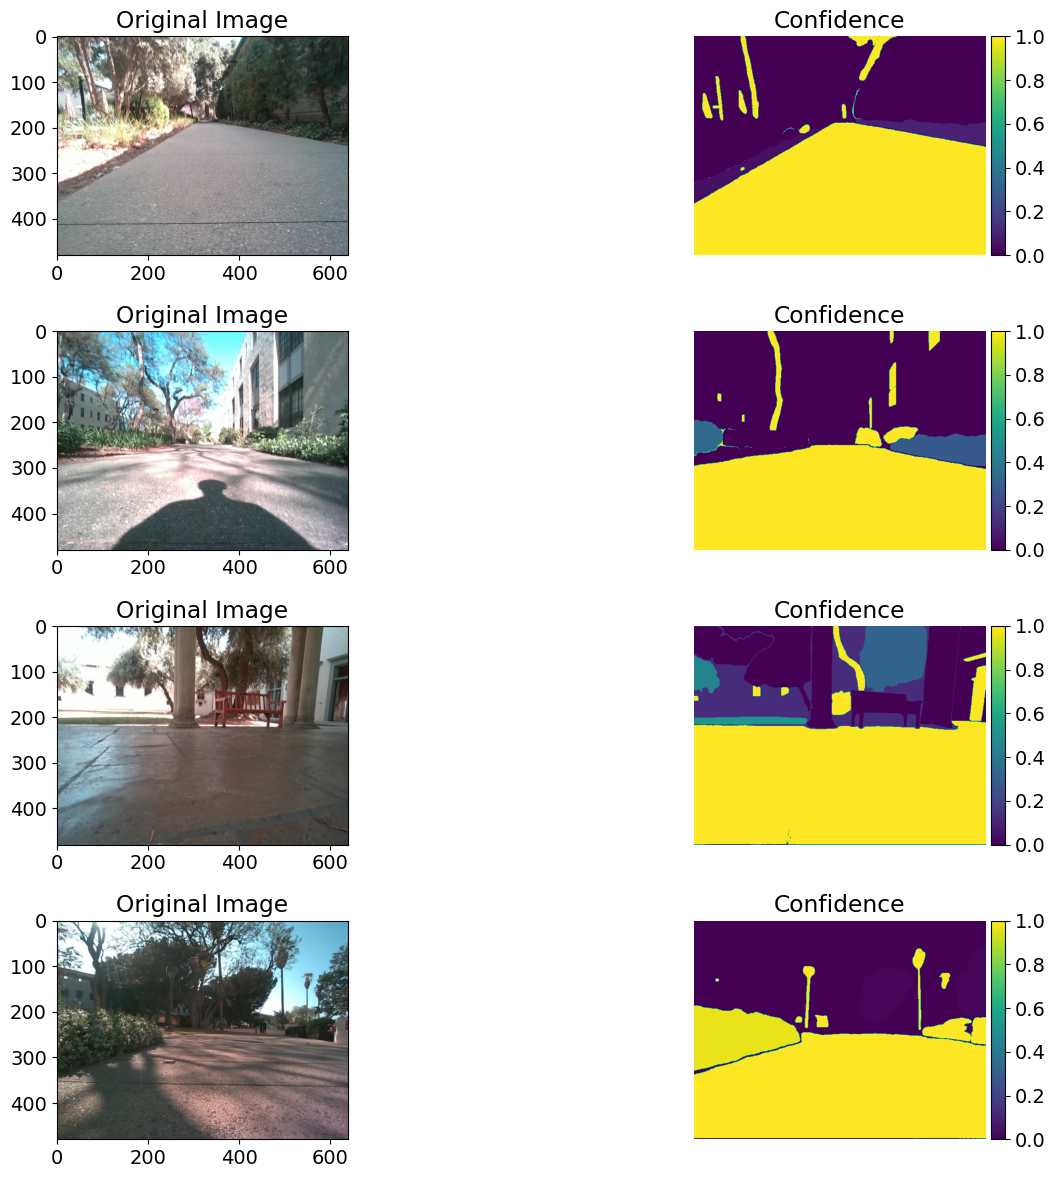

tensor([[[[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [ True,  True,  True,  ...,  True,  True,  True],
          [ True,  True,  True,  ...,  True,  True,  True],
          [ True,  True,  True,  ...,  True,  True,  True]]],


        [[[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [ True,  True,  True,  ...,  True,  True,  True],
          [ True,  True,  True,  ...,  True,  True,  True],
          [ True,  True,  True,  ...,  True,  True,  True]]],


        [[[ True,  True,  True,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [ True,  True,  True,  ...,  True,  T

In [8]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from src.tools import clear_folder
from scipy.ndimage import grey_closing,grey_opening
import torch.nn.functional as F

threso = 0.1
# plotter = Plotter(config=config)

def process_batch(batch,name):
    images = batch['image'].to(device)
    depths = batch['depth'].to(device)
    confidence = batch['confidence'].to(device)
    masks = batch['mask'].to(device)
    timestamps = batch['timestamp']
    segs = batch['seg'].to(device)
    outputs = model(images, depths,segs,masks)

    confidence_batch = criterion(outputs, masks, segs,confidence, 0, 0, True, True)
    confidence_batch  = confidence_batch > threso
    # batch['image'] = batch['image'][:4]
    # img2 = plotter.plot_batch_dataset(batch)
    # plt.figure(figsize=(20, 20))
    # plt.imshow(img2)
    # plt.axis('off')
    # plt.show()
    print(confidence_batch)
    labeled= (~confidence_batch.to(device)) & (masks.to(device) == 0)
    sum_unlabeled = np.sum((masks == 0).cpu().numpy())
    ratio = (np.sum(labeled.cpu().numpy()))/sum_unlabeled*100
    print("ratio",ratio)
    for i in range(len(confidence_batch)):
        confidence_segs = confidence_batch[i].squeeze(0).squeeze(0).cpu().numpy()
        # np.save(os.path.join(dataset_folder,name,"confidence",f"{timestamps[i]}.npy"), confidence_segs)
    

with torch.inference_mode():
    # clear_folder(os.path.join(dataset_folder,"train","confidence"))
    # clear_folder(os.path.join(dataset_folder,"valid_manually_labelled","confidence"))
    for batch in train_loader:
        process_batch(batch,"train")
        break
    
    # for batch in valid_loader:
        # process_batch(batch,"valid_manually_labelled")



In [9]:
from src.visualization.plotter import Plotter
import matplotlib.pyplot as plt
valid_manually_labelled_dataset2 = COTDataset(
    confidence=True,
    root_dir=check_file_path(dataset_folder,"train"), 
    transform_input=transform_builder.build_transforms_inputs(),
    transform_common=transform_builder.build_transform_common(), 
    config=config, 
)

valid_loader2 = DataLoader(
    valid_manually_labelled_dataset2, 
    batch_size=400, 
    shuffle=True,
    pin_memory=True,
    num_workers=config['ml_orchestrator']['num_workers']
)

plotter = Plotter(config=config)

for batch in valid_loader2:
    print(batch['image'].shape)
    images = batch['image']
    depths = batch['depth']
    confidence = batch['confidence']
    masks = batch['mask'].to(device)
    timestamps = batch['timestamp']

    confidence = confidence > 0.5
    labeled=(~confidence.to(device)) & (masks.to(device) == 0)
    sum_unlabeled = np.sum((masks == 0).cpu().numpy())
    ratio = (np.sum(labeled.cpu().numpy()))/sum_unlabeled*100
    print("ratio",ratio)
    # img = plotter.plot_confidence(images, confidence)
    # plt.figure(figsize=(20, 20))
    # plt.imshow(img)
    # plt.axis('off')
    # plt.show()
    # batch['image'] = batch['image'][:4]
    # img2 = plotter.plot_batch_dataset(batch)
    # plt.figure(figsize=(20, 20))
    # plt.imshow(img2)
    # plt.axis('off')
    # plt.show()
    


torch.Size([400, 3, 480, 640])
ratio 46.765434810333076
torch.Size([194, 3, 480, 640])
ratio 46.91831618150146


wandb: Network error (ReadTimeout), entering retry loop.
